In [1]:
import json
import pandas as pd
import gzip
import os
from urllib.request import urlopen

# Familiarize Yourself with the Dataset
In the lab sessions, we will work with the "All Beauty" category of the Amazon Review Data, and we will use the 5-core subset. You can download the dataset and find information about it here: https://nijianmo.github.io/amazon/index.html

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty_5.json.gz

--2022-02-26 21:34:26--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633507 (619K) [application/octet-stream]
Saving to: ‘All_Beauty_5.json.gz’

All_Beauty_5.json.g 100%[===================>] 618.66K  2.42MB/s    in 0.2s    

2022-02-26 21:34:27 (2.42 MB/s) - ‘All_Beauty_5.json.gz’ saved [633507/633507]



## Exercise 1
Download and import the 5-core dataset.

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty_5.json.gz')
print(len(df))

5269


## Exercise 2
Clean the dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any. How many observations does the cleaned dataset have?

In [4]:
df = df.sort_values(by=['reviewerID', 'asin', 'unixReviewTime'])
cleaned_dataset = df.dropna(subset=['overall']).drop_duplicates(subset=['reviewerID', 'asin'], keep = 'last').reset_index(drop=True)
print(len(cleaned_dataset))
cleaned_dataset.head()

4092


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"07 6, 2014",A105A034ZG9EHO,B0009RF9DW,{'Size:': ' 180'},K. Mras,yum,Five Stars,1404604800,NaN,NaN
1,5.0,True,"07 6, 2014",A105A034ZG9EHO,B000FI4S1E,NaN,K. Mras,yum,Five Stars,1404604800,NaN,NaN
2,5.0,True,"07 6, 2014",A105A034ZG9EHO,B000URXP6E,{'Size:': ' 180'},K. Mras,yum,Five Stars,1404604800,NaN,NaN
3,5.0,True,"07 6, 2014",A105A034ZG9EHO,B0012Y0ZG2,{'Size:': ' 180'},K. Mras,yum,Five Stars,1404604800,NaN,NaN
4,5.0,True,"08 13, 2013",A10JB7YPWZGRF4,B0009RF9DW,{'Size:': ' 45'},Amazon Customer,I continually get compliments on how wonderful...,Heaven !,1376352000,NaN,NaN


## Exercise 3
Create a test set by extracting the latest (in time) positively rated item (rating $\geq 4$) by each user. Remove users that do not appear in the training set. How many observations does the training and test set have?

In [5]:
cleaned_dataset = cleaned_dataset.sort_values(by=['reviewerID', 'unixReviewTime']).reset_index(drop=True)
# extracting the latest (in time) positively rated item (rating  ≥4 ) by each user. 
test_data_pre = cleaned_dataset[cleaned_dataset.overall >= 4.0].drop_duplicates(subset=['reviewerID'], keep='last')
# generate training data
training_data = cleaned_dataset.drop(test_data_pre.index)
print(len(training_data))

# Remove users that do not appear in the training set.
user_in_training = test_data_pre['reviewerID'].isin(training_data['reviewerID'])
test_data = test_data_pre[user_in_training]
print(len(test_data))

3133
949


## Exercise 4
### 4.1
Compute the number of ratings per user in the training set. What is the summary statistics of the number of ratings, and how does a histogram look like? <br>
Reflect on how a collaborative filtering and a content-based recommender system, respectively, will perform for users with few ratings.

In [6]:
number_of_rating = training_data.groupby(['reviewerID']).count()
print("summary statistics:")
number_of_rating.overall.describe()
# percentage = number_of_rating.groupby(['overall']).count() / 981.0
# percentage['reviewerName'].plot.bar()

summary statistics:


count    981.000000
mean       3.193680
std        0.610454
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        9.000000
Name: overall, dtype: float64

### 4.2
Compute the number of ratings per item in the training set. How does a barplot of the number of ratings ordered by decreasing frequency look like? <br>
Reflect on how it will affect the prediction process of a recommender system if only a small fraction of the items are rated frequently. <br>
<br>
Repeat this exercise on the test set and reflect on how the evaluation of a recommender system can be affected by popular items.

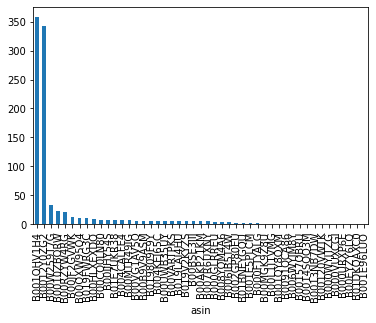

In [7]:
number_of_rating = test_data.groupby('asin').count().sort_values(by=['overall'], ascending=False)
number_of_rating['overall'].plot.bar()

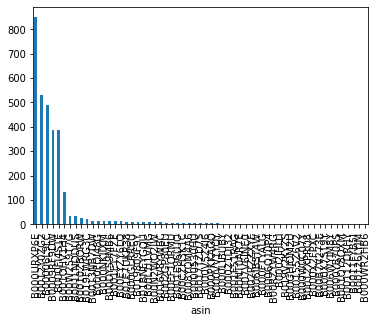

In [8]:
number_of_rating = training_data.groupby('asin').count().sort_values(by=['overall'], ascending=False)
number_of_rating['overall'].plot.bar()

### 4.3
Compute the mean rating per user in the training set. What is the summary statistics of the rating means? <br>

Repeat this exercise with mean rating per item.

In [9]:
number_of_rating = training_data.groupby('reviewerID').mean()
number_of_rating.overall.describe()

count    981.000000
mean       4.767839
std        0.719835
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: overall, dtype: float64

Repeat this exercise with mean rating per item.

In [10]:
number_of_rating = training_data.groupby('asin').mean()
number_of_rating.overall.describe()

count    59.000000
mean      3.993775
std       0.968168
min       1.000000
25%       3.576923
50%       4.213740
75%       4.705031
max       5.000000
Name: overall, dtype: float64